<a href="https://colab.research.google.com/github/Megancodes2017/Megancodes2017/blob/main/Quantrill_vs_Phillies_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.5/416.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 23.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pybaseball import playerid_lookup, statcast_pitcher, statcast_batter
import matplotlib.pyplot as plt

In [ ]:
pid_df = playerid_lookup('Quantrill', 'Cal')
print(pid_df[['name_last', 'name_first', 'key_mlbam']])

Gathering player lookup table. This may take a moment.
   name_last name_first  key_mlbam
0  quantrill        cal     615698


In [ ]:
pid = pid_df['key_mlbam'].iloc[0]

In [ ]:
# Get Quantrill's pitch data 2025
start_date = '2025-03-20'
end_date = '2025-08-28'
pitches = statcast_pitcher(start_date, end_date, pid)

Gathering Player Data


In [ ]:
# Filter to PA where PHI is batting
if 'bat_team' in pitches.columns:
  phillies_pitches = pitches[pitches['bat_team'] == 'PHI'].copy()
else:
  phillies_pitches = pitches[(pitches['home_team'] == 'PHI') | (pitches['away_team'] == 'PHI')].copy()

In [ ]:
print(f'Total Quantril pitches in 2025: {len(pitches):,}')
print(f'Pitches vs Phillies: {len(phillies_pitches):,}')

Total Quantril pitches in 2025: 2,061
Pitches vs Phillies: 216


In [ ]:
if 'pitch_name' not in phillies_pitches.columns and 'pitch_type' in phillies_pitches.columns:
  code2name = {
      'FF': 'four_seam', 'SI': 'sinker', 'FC': 'cutter', 'SL': 'slider',
      'CH': 'changeup', 'CU': 'curve', 'FS': 'splitter'
  }
  phillies_pitches['pitch_name'] = phillies_pitches['pitch_type'].map(code2name).fillna(phillies_pitches['pitch_type'])

In [ ]:
# Create outcome columns for simple metrics
def outcome_to_bases(ev):
  if pd.isna(ev):
    return 0
  ev = ev.lower()
  if 'single' in ev:
    return 1
  if 'double' in ev:
    return 2
  if 'triple' in ev:
    return 3
  if 'home_run' in ev or 'home run' in ev:
    return 4
  return 0

phillies_pitches['bases'] = phillies_pitches['events'].apply(outcome_to_bases)
# PA flag: events not null or description == hitintoplay or description contains walk or SO
phillies_pitches['is_pa'] = phillies_pitches['events'].notna() | phillies_pitches['description'].isin(['hit_into_play', 'field_out', 'hit_by_pitch'])

In [ ]:
# Aggregate per pitch type
group = phillies_pitches.groupby('pitch_name').agg(
    pitches = ('pitch_name', 'size'),
    PA = ('is_pa', 'sum'),
    hits = ('events', lambda s: s.str.contains('single|double|triple|home_run', case=False, na=False).sum()),
    total_bases = ('bases', 'sum'),
    walks = ('events', lambda s: s.str.contains('walk', case=False, na=False).sum()),
    strikeouts = ('events', lambda s: s.str.contains('strikeout', case=False, na=False).sum()),
    avg_ev = ('launch_speed', 'mean'),
    hard_hit_pct = ('launch_speed', lambda s: (s>=95).sum()/s.count() if s.count()>0 else pd.NA),
    whiff_rate = ('description', lambda s: (s == 'swinging_strike').sum() if s.count()>0 else pd.NA)
).reset_index()

In [ ]:
# Add computed stats
group['AVG'] = group['hits'] / group['PA']
group['SLG'] = group['total_bases'] / group['PA']
group['OBP'] = (group['hits'] + group['walks'] + group['strikeouts']) / (group['PA'] + group['walks'] + group['strikeouts'] + group['hits'])
group['ISO'] = group['SLG'] - group['AVG']
group = group.sort_values('PA', ascending=False)
print(group[['pitch_name', 'pitches', 'PA', 'AVG', 'OBP', 'SLG', 'ISO', 'avg_ev', 'hard_hit_pct', 'whiff_rate' ]])

        pitch_name  pitches  PA       AVG       OBP       SLG       ISO  \
5     Split-Finger       47  14  0.285714  0.222222  0.571429  0.285714   
2           Cutter       40  13  0.615385  0.409091  1.307692  0.692308   
3           Sinker       41  11  0.090909  0.214286  0.090909  0.000000   
1        Curveball       40   8  0.375000  0.333333  0.750000  0.375000   
0  4-Seam Fastball       32   7  0.428571  0.363636  1.000000  0.571429   
4           Slider       16   4  0.500000  0.333333  1.500000  1.000000   

       avg_ev  hard_hit_pct  whiff_rate  
5   90.817647      0.411765           2  
2   88.836364      0.545455           1  
3   79.525000      0.187500           1  
1   86.457143      0.285714           6  
0   83.221429      0.142857           1  
4  102.025000      0.750000           1  


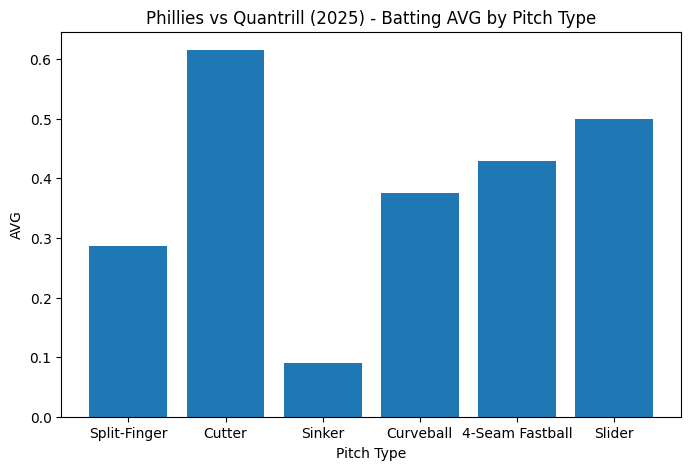

In [ ]:
# Plot AVG by pitch type
plt.figure(figsize=(8, 5))
plt.bar(group['pitch_name'], group['AVG'])
plt.title('Phillies vs Quantrill (2025) - Batting AVG by Pitch Type')
plt.ylabel('AVG')
plt.xlabel('Pitch Type')
plt.show()

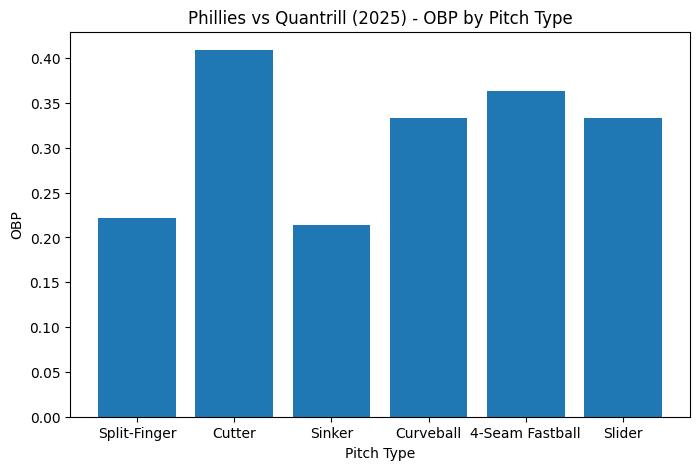

In [ ]:
# Plot by OBP
plt.figure(figsize=(8, 5))
plt.bar(group['pitch_name'], group['OBP'])
plt.title('Phillies vs Quantrill (2025) - OBP by Pitch Type')
plt.ylabel('OBP')
plt.xlabel('Pitch Type')
plt.show()

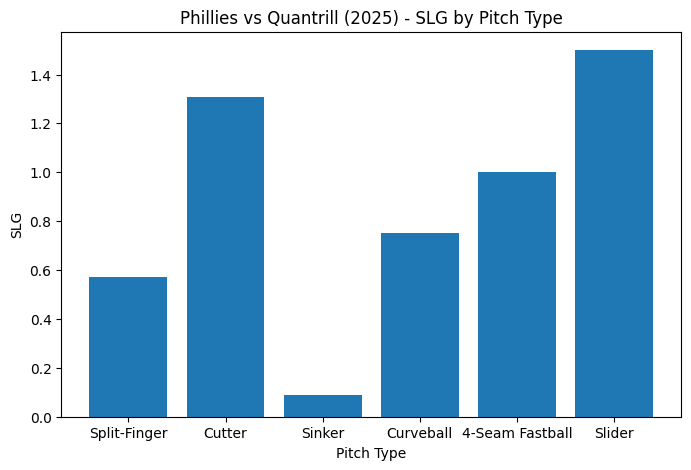

In [ ]:
# Plot by SLG
plt.figure(figsize=(8, 5))
plt.bar(group['pitch_name'], group['SLG'])
plt.title('Phillies vs Quantrill (2025) - SLG by Pitch Type')
plt.ylabel('SLG')
plt.xlabel('Pitch Type')
plt.show()